In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [2]:
import galsim
from mdetsims import PowerSpectrumPSF

In [3]:
import joblib

def _get_psf_variation(func, n=20):
    start = 0
    end = start + 225
    jobs = []
    
    fwhm = np.zeros((n, n))
    g1 = np.zeros((n, n))
    g2 = np.zeros((n, n))

    def __func(j, x):
        retvals = []
        for i, y in enumerate(np.linspace(start, end, n)):
            _psf = func(x, y)
            _psf = _psf.drawImage(scale=0.25, nx=17, ny=17)
            mom = galsim.hsm.FindAdaptiveMom(_psf)
            retvals.append((i, j, mom.moments_sigma * 0.25 * 2.355, 
                mom.observed_shape.g1, mom.observed_shape.g2))
        return retvals
    
    for j, x in enumerate(np.linspace(start, end, n)):
        jobs.append(joblib.delayed(__func)(j, x))
                          
    outputs = joblib.Parallel(
        n_jobs=-1, verbose=10, 
        max_nbytes=None, backend='loky')(jobs)
    for o in outputs:
        for i, j, _fwhm, _g1, _g2 in o:
            fwhm[i, j] = _fwhm
            g1[i, j] = _g1
            g2[i, j] = _g2

    return fwhm, g1, g2

from mdetsims.plots import plot_psf_model

In [9]:
rng = np.random.RandomState()
noise_level = 0
psfs = [
    PowerSpectrumPSF(
        rng=rng,
        im_width=225, buff=225//2, scale=0.25, trunc=1, 
        noise_level=noise_level,
        median_seeing=0.8)
    for i in range(30)]

psf = galsim.Sum([p.getPSF(galsim.PositionD(x=10, y=10)) for p in psfs]).withFlux(1)

psf.flux

1.0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    4.3s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.2s finished


1.2350130702334086 0.1563260701628865 0.11097726621812615


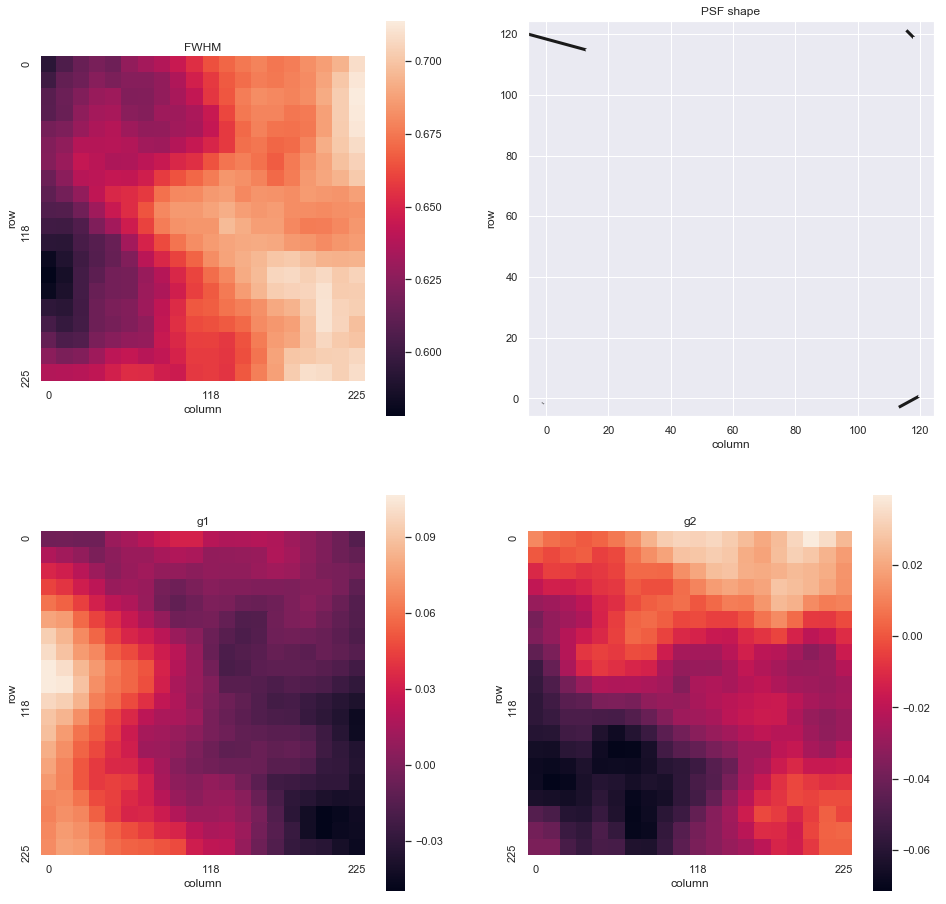

In [11]:
n = 20
func = lambda x,y: psfs[2].getPSF(galsim.PositionD(x=x, y=y))

fwhm, g1, g2 = _get_psf_variation(func, n=n)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
plot_psf_model(fwhm, g1, g2, 225, axs)
print(fwhm.max()/fwhm.min(), g1.max() - g1.min(), g2.max() - g2.min())

In [ ]:
func = lambda x,y: psfs[1].getPSF(galsim.PositionD(x=x, y=y))

n = 225
fwhm, g1, g2 = _get_psf_variation(func, n=n)

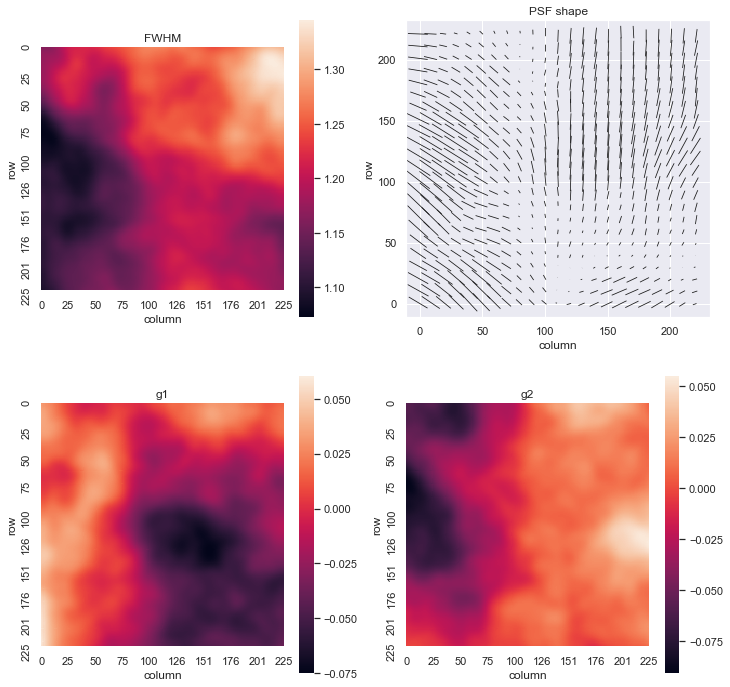

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
plot_psf_model(fwhm, g1, g2, 225, axs)
plt.savefig('/Users/Matt/Desktop/pspsf.png', bbox_inches='tight', pad_inches=0)

In [20]:
import treecorr

y, x = np.mgrid[:225, :225] * 0.263
cat = treecorr.Catalog(
    x=y.ravel(), y=x.ravel(), g1=g1.ravel(), g2=g2.ravel(),
    x_units='arcsec', y_units='arcsec')

gg = treecorr.GGCorrelation(
    nbins=50, min_sep=1, max_sep=60, bin_slop=0.1,
    sep_units='arcsec')

gg.process_auto(cat)
gg.finalize(np.std(g1)**2, np.std(g2)**2)

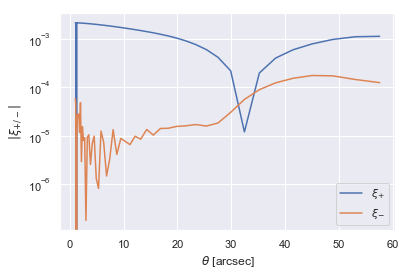

In [21]:
plt.figure()
plt.semilogy(gg.rnom, np.abs(gg.xip), label=r'$\xi_{+}$')
plt.semilogy(gg.rnom, np.abs(gg.xim), label=r'$\xi_{-}$')
plt.xlabel(r'$\theta$ [arcsec]')
plt.ylabel(r'$|\xi_{+/-}|$')
plt.legend(loc=4)
plt.savefig('/Users/Matt/Desktop/psxi.png', bbox_inches='tight', pad_inches=0)

In [ ]:
plt.figure(figsize=(8, 8))
psf_im = psf.getPSF(galsim.PositionD(x=10, y=10)).drawImage(scale=0.25, nx=17, ny=17)
print(psf_im.calculateFWHM())
sns.heatmap(psf_im.array, square=True)